In [1]:
import pandas as pd
import numpy as np
pd.set_option("chained_assignment", None)
pd.set_option("display.max_rows", 5000)
pd.set_option("display.max_columns", 5000)
pd.set_option("display.width", 10000)

def load_priorband_data():
    df = pd.read_parquet("data_for_anton.parquet")
    df=df.reset_index()
    df_collection=[]
    for seed_nr in range(50):
        partial_df=df[["benchmark","prior","algorithm","used_fidelity"]]
        partial_df["value"]=df[f"seed-{seed_nr}"]
        partial_df["seed"]=seed_nr
        df_collection.append(partial_df)
        print(f"Seed {seed_nr+1}/50", end="\r", flush=True)
    return pd.concat(df_collection,ignore_index=True)

df=load_priorband_data()

In [2]:
algo_dict={"rs_hb_pb":["random_search","hyperband","pb_mutation_dynamic_geometric-default-at-target"]}
algo_dict["rs_pb"]=["random_search","pb_mutation_dynamic_geometric-default-at-target"]
algo_dict["hb_pb"]=["hyperband","pb_mutation_dynamic_geometric-default-at-target"]
prior_dict={"good+bad":["at25","bad"]}
benchmarks=["jahs_cifar10","jahs_colorectal_histology","jahs_fashion_mnist","lcbench-126026","lcbench-167190","lcbench-168330","lcbench-168910","lcbench-189906","cifar100_wideresnet_2048","imagenet_resnet_512","lm1b_transformer_2048","translatewmt_xformer_64"]

for priortype in df["prior"].unique():
    prior_dict[priortype]=[priortype]


df_dict={}
for prior_key,prior_value in prior_dict.items():
    df_dict[prior_key]={}
    for b_n,benchmark in enumerate(benchmarks):
        print(f"Prior {prior_key}, Benchmark {b_n+1}/{len(benchmarks)}      ", end="\r", flush=True)
        df_dict[prior_key][benchmark]={}
        for algo_key,algo_value in algo_dict.items():
            df_dict[prior_key][benchmark][algo_key]=df.loc[(df["prior"].isin(prior_value))&(df["algorithm"].isin(algo_value))&(df["benchmark"]==benchmark)].reset_index(drop=True)

In [16]:
import tabulate
from autorank import autorank, create_report, plot_stats
import matplotlib.pyplot as plt
table10={}
table10["algo_group"]="rs_hb_pb"
table10["algorithms"]=algo_dict[table10["algo_group"]].copy()
table10["priors"]=["at25","bad","good+bad"]
table10["benchmarks"]=benchmarks
table10["max_f"]=np.linspace(1,12,100)
label_dict={'random_search': 'RS', 'hyperband': 'HB', 'pb_mutation_dynamic_geometric-default-at-target': 'PB', 'jahs_cifar10': 'JAHS-C10', 'jahs_colorectal_histology': 'JAHS-CH', 'jahs_fashion_mnist': 'JAHS-FM', 'lcbench-126026': 'LC-126026', 'lcbench-167190': 'LC-167190', 'lcbench-168330': 'LC-168330', 'lcbench-168910': 'LC-168910', 'lcbench-189906': 'LC-189906', 'cifar100_wideresnet_2048': 'PD1-Cifar100', 'imagenet_resnet_512': 'PD1-ImageNet', 'lm1b_transformer_2048': 'PD1-LM1B', 'translatewmt_xformer_64': 'PD1-WMT'}

table10["dataset"]={}
table10["mean_std"]={}
for p_n,prior in enumerate(table10["priors"]):
    table10["dataset"][prior]={}
    table10["mean_std"][prior]={}
    for f_n,max_f in enumerate(table10["max_f"]):
        table10["dataset"][prior][max_f]={}
        labels=[]
        for algo in table10["algorithms"]:
            labels.append(label_dict[algo])
        table10["mean_std"][prior][max_f]=pd.DataFrame(columns=["benchmark"]+labels)
        for benchmark in table10["benchmarks"]:
            table10["dataset"][prior][max_f][benchmark]=pd.DataFrame()
            means_std=[]
            for algorithm in table10["algorithms"]:
                df_at_point=df_dict[prior][benchmark][table10["algo_group"]].loc[df_dict[prior][benchmark][table10["algo_group"]]["algorithm"]==algorithm]
                df_at_point=df_at_point.loc[df_at_point["used_fidelity"]<=max_f]
                column=[]
                for seed in df_at_point["seed"].unique():
                    column.append(df_at_point.loc[df_at_point["seed"]==seed].iloc[-1]["value"])
                table10["dataset"][prior][max_f][benchmark][algorithm]=column
                means_std.append(str(np.round(table10["dataset"][prior][max_f][benchmark][algorithm].mean(),3))+" ± "+str(np.round(table10["dataset"][prior][max_f][benchmark][algorithm].std(),3)))
            table10["mean_std"][prior][max_f].loc[len(table10["mean_std"][prior][max_f])]=[label_dict[benchmark]]+means_std
            print(f"Prior {prior} ({p_n+1}), Fidelity {f_n+1}/{len(table10['max_f'])}          ", end="\r", flush=True)
            # print(table10["mean_std"][prior][max_f].to_markdown(index=False),"\n")
            # print(f"  {max_f}x  {prior}-Prior  {benchmark}")
            # plot_stats(autorank(table10["dataset"][prior][max_f][benchmark]),allow_insignificant=True)
            # plt.show()


In [17]:
import warnings
warnings.filterwarnings("ignore","p-value may not be accurate for N > 5000.")
warnings.filterwarnings("ignore","Input data for shapiro has range zero. The results may not be accurate.")
warnings.filterwarnings("ignore","invalid value encountered in scalar divide")

fig5={}
fig5["algo_group"]="rs_hb_pb"
fig5["algorithms"]=algo_dict[table10["algo_group"]].copy()
fig5["priors"]=["good+bad","at25","bad"]
fig5["benchmarks"]=benchmarks
fig5["max_f"]=np.linspace(1,12,100)


resultframes={}
averages={}
for p_n,prior in enumerate(fig5["priors"]):
    resultframes[prior]={}
    averages[prior]={}
    for f_n,max_f in enumerate(fig5["max_f"]):
        print(f"Prior {prior} ({p_n+1}), Fidelity {f_n+1}/{len(table10['max_f'])}        ", end="\r", flush=True)
        resultframes[prior][max_f]={}
        for benchmark in fig5["benchmarks"]:
            resultframes[prior][max_f][benchmark]=autorank(table10["dataset"][prior][max_f][benchmark])[0]

    for algo in fig5["algorithms"]:        
        averages[prior][algo]=[]
        for max_f in fig5["max_f"]:
            average=0
            for benchmark in fig5["benchmarks"]:
                average+=resultframes[prior][max_f][benchmark].loc[algo]["meanrank"]
            average/=len(fig5["benchmarks"])
            averages[prior][algo].append(4-average)

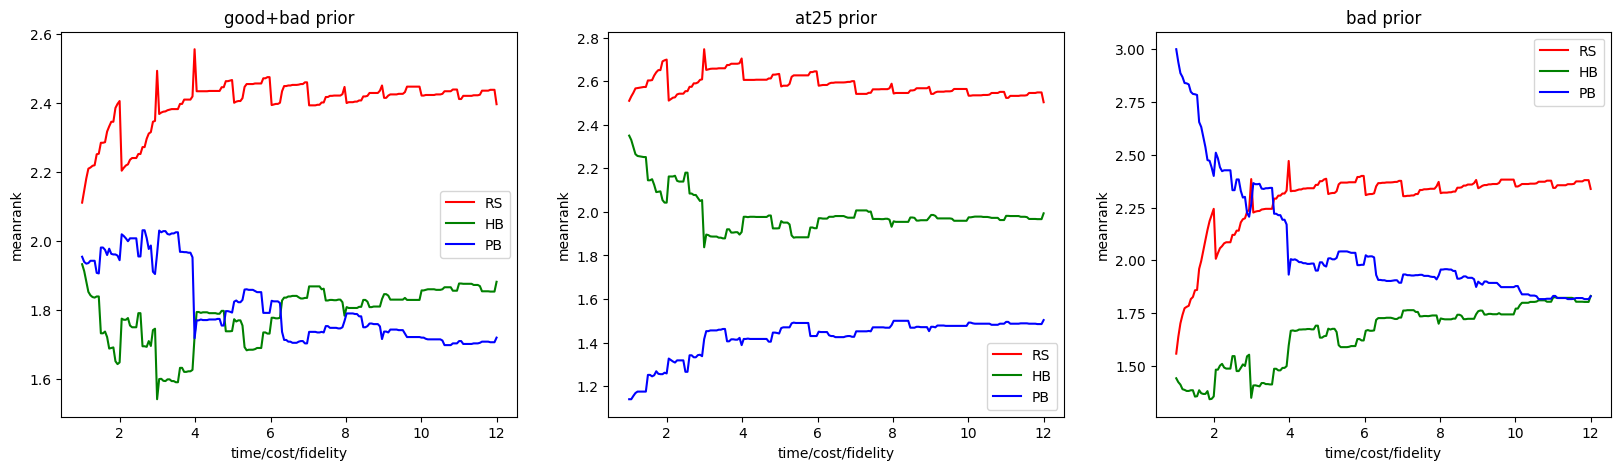

In [13]:
x_data=np.linspace(1,12,200)
color_dict={"random_search":"red","hyperband":"green","pb_mutation_dynamic_geometric-default-at-target":"blue","priorband":"blue"}


_, axis = plt.subplots(ncols=len(fig5["priors"]),figsize=(20, 5))
for p_n,prior in enumerate(fig5["priors"]):
    for s_n,system in enumerate(fig5["algorithms"]):
        axis[p_n].errorbar(
            x_data,
            averages[prior][system],
            fmt="-",
            label=label_dict[system],
            color=color_dict[system]
        )
    axis[p_n].set_xlabel("time/cost/fidelity")
    axis[p_n].set_ylabel("meanrank")
    axis[p_n].set_title(f"{prior} prior")
    axis[p_n].legend()